Elevation changes from SAR Amplitude images
==============

This notebook shows how to get elevation changes from SAR amplitude images using shape from shading techniques explained in (cite article). In this notebook we show the results for a Shishaldin dataset using TerraSAR-X images and an ArticDEM. Unfortunately the notebook cannot be rerun because it needs the original slc files and DEM that are not open source. 

## Importing libraries

'sfs' coregisters the slc images with a DEM

In [1]:
%matplotlib inline
from mosart import sfs
from mosart import lsquares
import numpy as np
import matplotlib.pyplot as plt
import h5py
import multiprocessing
from functools import partial
import matplotlib.image as image
import datetime as dt
import matplotlib.style
import matplotlib as mpl
import datetime as dt
mpl.rcParams.update(mpl.rcParamsDefault)

## H5 file names

The variable 'cor_stack' will contain the name of the h5 file where all the coregistered images and DEM will be. The variable 'pre_stack' will contain the name of the h5 file that will have the area of interest and the gradient of the given DEM.

In [2]:
cor_stack='projections_alos.h5'
pre_stack='ascending.h5'

## Coregistration of slcs

In the next cell we have the rutine that coregisters all slcs images contain in the folder 'data/slcs'. The output filename will be given by cor_stack. 

**THIS RUTINE USES ISCE FOR COREGISTRATION**.

In [3]:
#Coregistering SAR images with the earliest image

#sfs.coregistration_alos('alos_list.txt')

### Plotting coregistered image and AOI

'sfs' helps to get the area of interest in radar coordinates using a lon/lat box. 

<IPython.core.display.Javascript object>


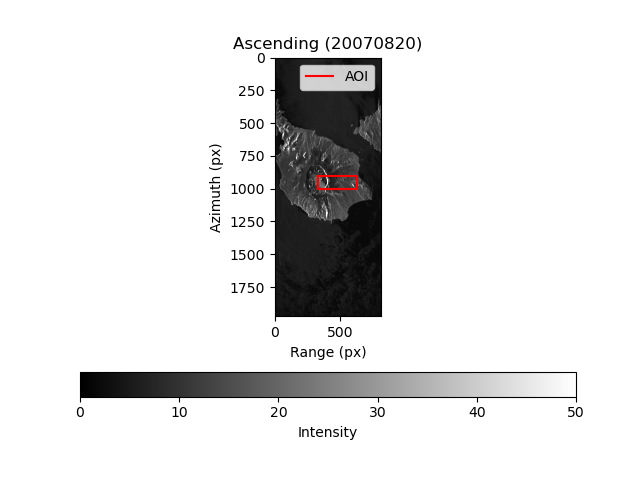

In [4]:
%matplotlib notebook
#Reading h5 file with coregistered images
h5i=h5py.File(cor_stack,'r')
keys=[key for key in h5i.keys() if key.isdigit()]
lonrdr=h5i['lon'][:]
latrdr=h5i['lat'][:]
amps=h5i[keys[0]][:]
h5i.close()

#Getting AOI in radar coordinates corresponding to certain longitudes and latitudes
xs=[330,630]
ys=[900,1000]
x0=xs[0]
y0=ys[0]
xsizet=xs[-1]-xs[0]
ysizet=ys[-1]-ys[0]
#Getting AOI in geographic coordinates corresponding to certain longitudes and latitudes
#x0,y0,xsizet,ysizet=sfs.get_box2(lonrdr,latrdr,lons=lons,lats=lats)

#Plotting a coregistered image and the AOI
plt.figure()
plt.title('Ascending ('+keys[1]+')')
plt.imshow(amps,cmap='gray',vmin=0,vmax=50)
plt.colorbar(label='Intensity',orientation='horizontal')
plt.plot([x0,x0,x0+xsizet,x0+xsizet,x0],[y0,y0+ysizet,y0+ysizet,y0,y0],color='red',label='AOI')
plt.xlabel('Range (px)')
plt.ylabel('Azimuth (px)')
plt.legend()

plt.show()

### Removing speckle from the amplitude image

MoSARt uses a non-local means filter to remove the speckle but the values depend on the satellite 

<IPython.core.display.Javascript object>


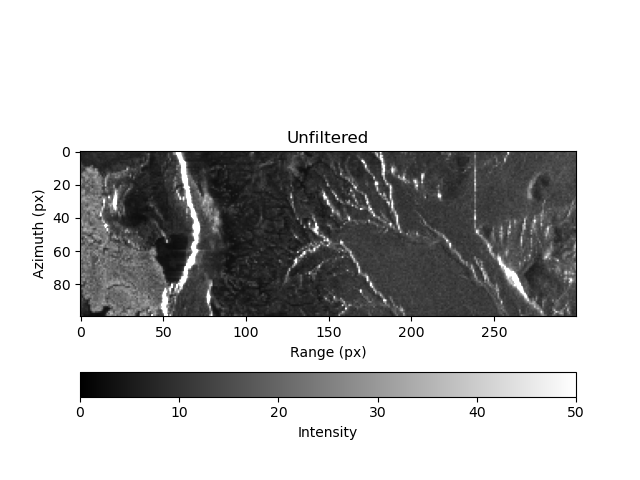

<IPython.core.display.Javascript object>


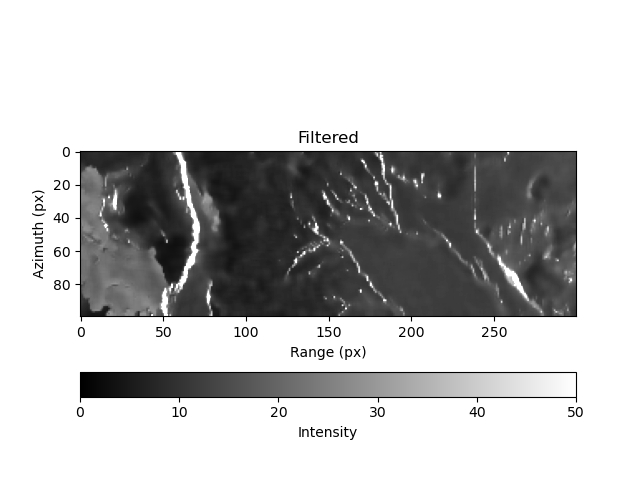

In [5]:
from skimage.restoration import denoise_nl_means

amps_clip=amps[ys[0]:ys[1],xs[0]:xs[1]]

sigma_amp=5
patch_kw = dict(patch_size=2,      # 5x5 patches
                patch_distance=2,  # 13x13 search area
                )
famps=denoise_nl_means(amps_clip, h=0.6 * sigma_amp, sigma=sigma_amp, fast_mode=True, **patch_kw)

plt.figure()
plt.title('Unfiltered')
plt.imshow(amps_clip,cmap='gray',vmin=0,vmax=50)
plt.colorbar(label='Intensity',orientation='horizontal')
plt.xlabel('Range (px)')
plt.ylabel('Azimuth (px)')

plt.figure()
plt.title('Filtered')
plt.imshow(famps,cmap='gray',vmin=0,vmax=50)
plt.colorbar(label='Intensity',orientation='horizontal')
plt.xlabel('Range (px)')
plt.ylabel('Azimuth (px)')
plt.show()

## Preprocessing

The 'preprocessing' function clip the AOI and calculates the gradient of the given DEM along range coordinates 

In [6]:
#Creating new h5file clipping the AOI and calculating DEM gradient
sfs.preprocessing(xs=xs,ys=ys,projections=cor_stack,path='A',sigma_amp=sigma_amp,gaussian=True,patch_kw=patch_kw)

Preprocessing for  20070705
Preprocessing for  20070820
Preprocessing for  20071005
Preprocessing for  20080822
Preprocessing for  20081007
Preprocessing for  20090825
Preprocessing for  20091010
Preprocessing for  20100713
Preprocessing for  20101013


### Plots for AOI

Here we plot the area of interest around the Shishaldin crater and the gradient of the ArcticDEM.

<IPython.core.display.Javascript object>


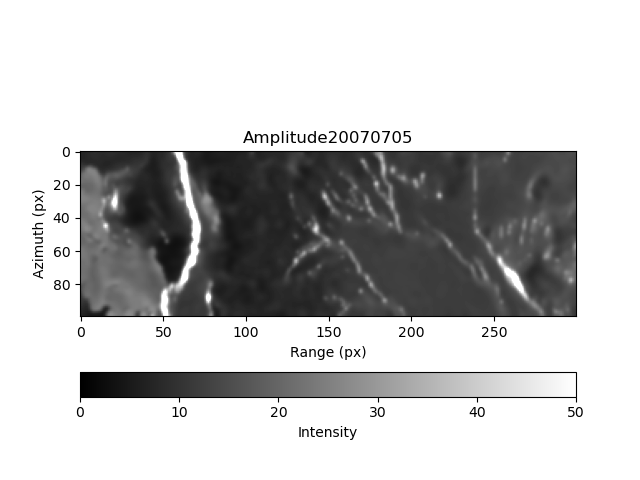

In [7]:
index=0

h5i=h5py.File(pre_stack,'r')
keys=[key for key in h5i.keys() if key.isdigit()]
amp=h5i[keys[index]][:]
grd=h5i['grad'][:]
dem=h5i['dem'][:]
tamps=np.array([h5i[key][:] for key in keys])
h5i.close()

plt.figure()
plt.title('Amplitude'+keys[index])
plt.imshow(amp,cmap='gray',vmin=0,vmax=50)
plt.colorbar(label='Intensity',orientation='horizontal')
plt.xlabel('Range (px)')
plt.ylabel('Azimuth (px)')
plt.show()

## Making Weight matrix

This cell creates the weight matrix for the inversion

<IPython.core.display.Javascript object>


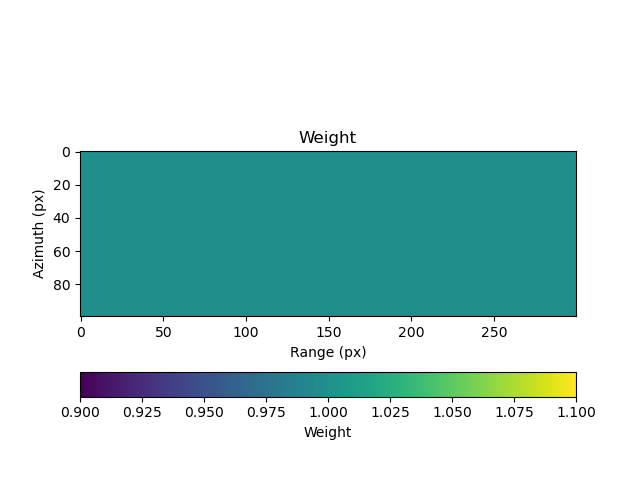

In [8]:
%matplotlib notebook
#Reading amplitude image for the AOI
h5i=h5py.File(pre_stack,'r')
keys=[key for key in h5i.keys() if key.isdigit()]
amp=h5i[keys[0]][:]
grd=h5i['grad'][:]
dem=h5i['dem'][:]
tamps=np.array([h5i[key][:] for key in keys])
h5i.close()

weights=np.ones(tamps.shape)*1

plt.figure()
plt.title('Weight')
plt.imshow(weights[0,:,:])
plt.colorbar(orientation='horizontal',label='Weight')
plt.xlabel('Range (px)')
plt.ylabel('Azimuth (px)')
plt.show()

## Reconstruction of DEMs

The next cells shows the process to construct a DEM per amplitude image

### Standard deviation on amplitude images

We need to calculate the standar deviation on the amplitude images through time, to assign weights when the inversion is made

### Construction of DEMs

The library 'lsquares' makes the inversions using a least squares approach. Here we paralellize to optimize the calculation time.

In [9]:
#Construction of DEMs
demdefs=[]
def onedem(i,keys,weights):
    key=keys[i]
    weight=weights[i,:,:]
    demdef,grddef,weights=lsquares.getdem(key,h5file='ascending.h5',weight=weight)
    return demdef,grddef,'d'
pool = multiprocessing.Pool(processes=13)
subrutina=partial(onedem,keys=keys,weights=weights)
demdefs,grddefs,nada=zip(*pool.map(subrutina, range(len(keys))))
pool.close()
pool.join()

Start DEM for 20070705
Start DEM for 20070820
Start DEM for 20071005
Start DEM for 20080822Finished DEM for
 20070705
Start DEM forFinished DEM for  2008100720070820

Start DEM forFinished DEM for  2009082520071005

Finished DEM for 20080822Start DEM for
 20091010
Start DEM for Finished DEM for20100713 
20081007
Start DEM forFinished DEM for  2009082520101013

Finished DEM for 20091010
Finished DEM for 20100713
Finished DEM for 20101013


### Plot of ArticDEM and reconstructed DEM

Here we show the original ArticDEM and a reconstructed DEM

<IPython.core.display.Javascript object>


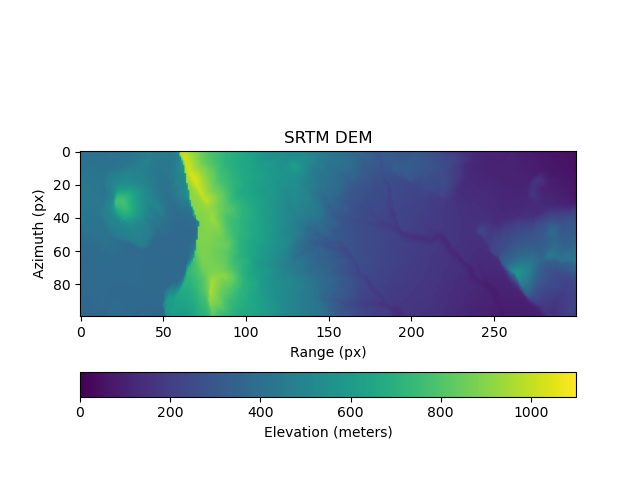

<IPython.core.display.Javascript object>


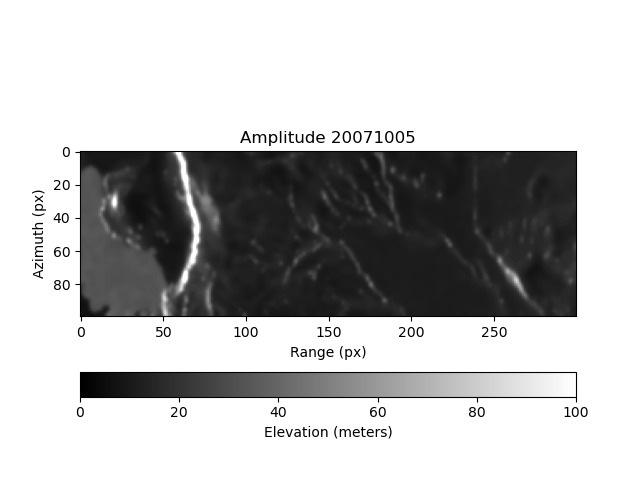

<IPython.core.display.Javascript object>


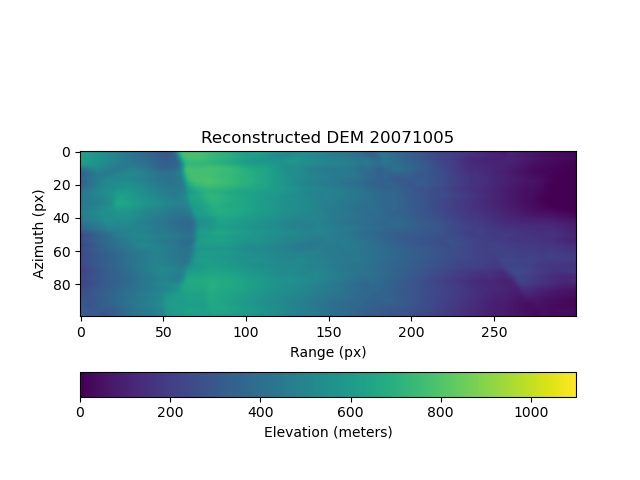

In [10]:
index=2

plt.figure()
plt.title('SRTM DEM')
plt.imshow(dem,vmin=0,vmax=1100)
plt.colorbar(label='Elevation (meters)',orientation='horizontal')
plt.xlabel('Range (px)')
plt.ylabel('Azimuth (px)')

plt.figure()
plt.title('Amplitude '+keys[index])
plt.imshow(tamps[index],vmin=0,vmax=100,cmap='gray')
plt.colorbar(label='Elevation (meters)',orientation='horizontal')
plt.xlabel('Range (px)')
plt.ylabel('Azimuth (px)')

plt.figure()
plt.title('Reconstructed DEM '+keys[index])
plt.imshow(demdefs[index],vmin=0,vmax=1100)
plt.colorbar(label='Elevation (meters)',orientation='horizontal')
plt.xlabel('Range (px)')
plt.ylabel('Azimuth (px)')

plt.show()

## Calculate elevation changes

Here we calculate the changes in elevation taking one slice as reference

<IPython.core.display.Javascript object>


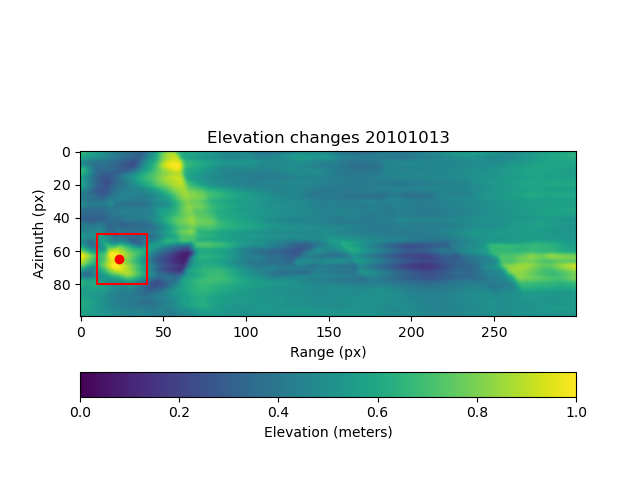

In [11]:
index=8
reference=2

changes=[]
for demdef in demdefs:
    changes.append(demdef-demdefs[reference])
changes=np.array(changes)

plt.figure()
plt.title('Elevation changes '+keys[index])
plt.imshow(changes[index],vmin=-300,vmax=300)
plt.plot([10,10,40,40,10],[50,80,80,50,50],c='red')
plt.scatter([23],[65],c='red')
plt.colorbar(label='Elevation (meters)',orientation='horizontal')
plt.xlabel('Range (px)')
plt.ylabel('Azimuth (px)')

plt.show()

### Time series

Here we plot a time series for a new cone in Okmok caldera

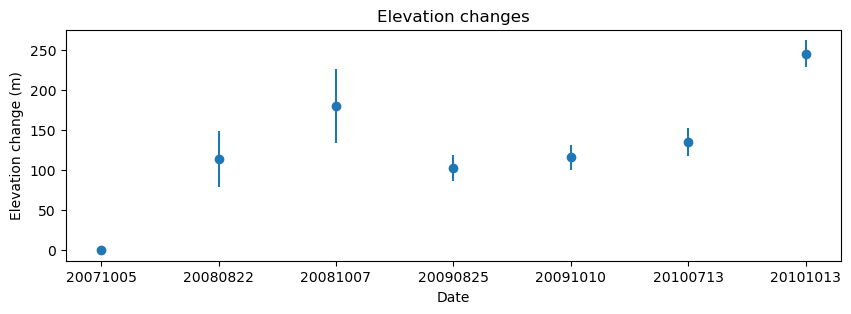

In [13]:
%matplotlib inline

errors=[np.std(changes[i,0:40,250::]) for i in range(reference,changes.shape[0])]

plt.figure(figsize=(10,3))
plt.title('Elevation changes')
plt.errorbar(np.array(keys)[reference::],changes[reference::,65,23],yerr=errors,marker='o',linestyle = 'None',)
plt.xlabel('Date')
plt.ylabel('Elevation change (m)')

plt.show()

## Geocoding results

We can use sfs library to georeference the results

In [14]:
geochanges,extent=sfs.georeference(pre_stack,array=changes,pixel_size=0.001)

/home/mario/MoSARt/ESAR/sfs.py:548: RuntimeWarning: Mean of empty slice
  geodef[k,i,j]=np.nanmean(change[cond])


<IPython.core.display.Javascript object>


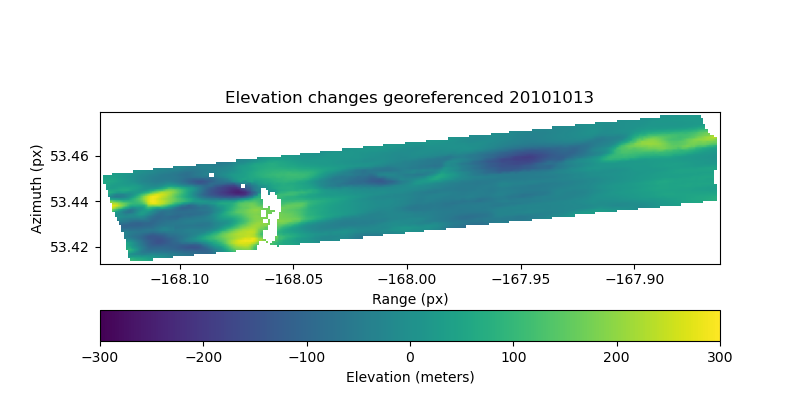

In [15]:
%matplotlib notebook

plt.figure(figsize=(8,4))
plt.title('Elevation changes georeferenced '+keys[index])
plt.imshow(geochanges[index],extent=extent,vmin=-300,vmax=300)
plt.colorbar(label='Elevation (meters)',orientation='horizontal')
plt.xlabel('Range (px)')
plt.ylabel('Azimuth (px)')

plt.show()

In [16]:
geoamps,extent=sfs.georeference(pre_stack,array=tamps,pixel_size=0.001)

<IPython.core.display.Javascript object>


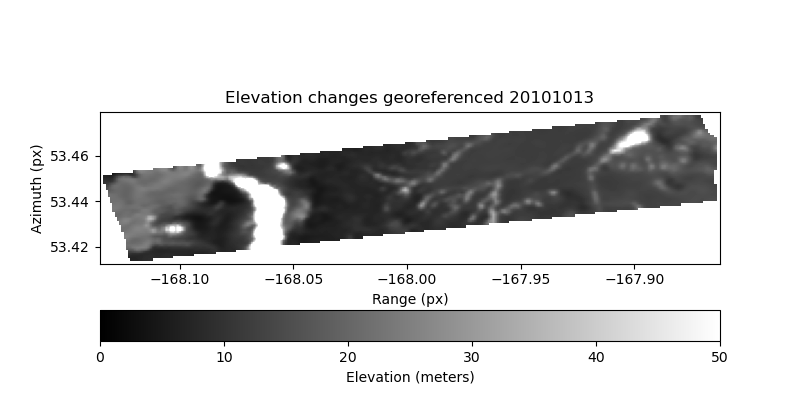

In [17]:
%matplotlib notebook

plt.figure(figsize=(8,4))
plt.title('Elevation changes georeferenced '+keys[index])
plt.imshow(geoamps[0],extent=extent,vmin=0,vmax=50,cmap='gray')
plt.colorbar(label='Elevation (meters)',orientation='horizontal')
plt.xlabel('Range (px)')
plt.ylabel('Azimuth (px)')

plt.show()